In [1]:
import pandas as pd
import numpy as np
import csv
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import time
import xgboost as xgb
import scipy
from geopy import distance
import geopy
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar
from sklearn import preprocessing


%matplotlib inline
sns.set()
plt.rcParams['figure.figsize'] = [16, 10]
pd.set_option('float_format', '{:f}'.format)

#### Read Data

In [2]:
PATH_TRAIN_DATASET = './data/train.csv'
PATH_TEST_DATASET = './data/test.csv'
PATH_SAMPLE_SUMBISSION = './data/sample_submission.csv'

In [3]:
df_train = pd.read_csv(PATH_TRAIN_DATASET, infer_datetime_format=True,parse_dates=['pickup_datetime'], index_col='id')

#### A brief description of the data

As mentioned in the challenge's page, the provided training dataset contains the following fields, as can be verified bellow:

- `id` - a unique identifier for each trip
- `vendor_id` - a code indicating the provider associated with the trip record
- `pickup_datetime` - date and time when the meter was engaged
- `dropoff_datetime` - date and time when the meter was disengaged
- `passenger_count` - the number of passengers in the vehicle (driver entered value)
- `pickup_longitude` - the longitude where the meter was engaged
- `pickup_latitude` - the latitude where the meter was engaged
- `dropoff_longitude` - the longitude where the meter was disengaged
- `dropoff_latitude` - the latitude where the meter was disengaged
- `store_and_fwd_flag` - This flag indicates whether the trip record was held in vehicle memory before sending to the vendor because the vehicle did not have a connection to the server -`Y`=store and forward; `N`=not a store and forward trip
- `trip_duration` - duration of the trip in seconds

In [4]:
df_train.columns

Index(['vendor_id', 'pickup_datetime', 'dropoff_datetime', 'passenger_count',
       'pickup_longitude', 'pickup_latitude', 'dropoff_longitude',
       'dropoff_latitude', 'store_and_fwd_flag', 'trip_duration'],
      dtype='object')

In [5]:
df_train.head(5)

,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
id,,,,,,,,,,
id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


#### No Null Columns

It's important to notice that the provided database has been already preprocessed and cleaned, so no null values can be found in the base.

In [6]:
df_train.isnull().sum()

vendor_id             0
pickup_datetime       0
dropoff_datetime      0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
trip_duration         0
dtype: int64

## Analyzing the whole Dataset

#### Prepare the data for analysis

Before the analysis, a few steps must be done to prepare the data. Also, the dropoff_datetime column will be dropped because it's redundant since we have the trip_duration.

In [7]:
df_train['pickup_datetime'] = df_train['pickup_datetime'].dt.to_pydatetime()
df_train.drop('dropoff_datetime', axis=1, inplace=True)

#### Trip Duration

Since trip duration is the target variable, it will be the first to be checked. After aplying the describe function, a few strange values appear, like the min and max values, 1s and 3526282s (almost 980h) respectively. Trips with a such a low or high values for duration can decrease the accuracy of our model.

In [8]:
df_train['trip_duration'].describe()

count   1458644.000000
mean        959.492273
std        5237.431724
min           1.000000
25%         397.000000
50%         662.000000
75%        1075.000000
max     3526282.000000
Name: trip_duration, dtype: float64

To get rid of the outliers, lets apply the the [Interquartile Range](https://en.wikipedia.org/wiki/Interquartile_range) technique

In [9]:
Q1 = df_train['trip_duration'].quantile(0.25)
Q3 = df_train['trip_duration'].quantile(0.75)
IQR = Q3 - Q1
filter_IQR = ~((df_train['trip_duration'] < (Q1 - 1.5 * IQR)) | (df_train['trip_duration'] > (Q3 + 1.5 * IQR)))
df_train = df_train[filter_IQR]
df_train['trip_duration'].describe()

count   1384424.000000
mean        731.702593
std         448.108071
min           1.000000
25%         384.000000
50%         632.000000
75%         991.000000
max        2092.000000
Name: trip_duration, dtype: float64

In [10]:
df_train = df_train[df_train['trip_duration'] > 1]
df_train = df_train[df_train['trip_duration'] < 7200]

/home/luciano/Install/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


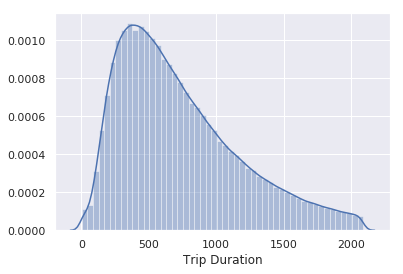

In [11]:
sns.distplot(df_train['trip_duration'], axlabel='Trip Duration')

#### Analyzing the Lat-Long Columns

To understand the distribution we must plot the values for each of the Latitude and Longitude provided. From the graph is possible to see that there are some datapoints from trips starting and finishing outside NYC.

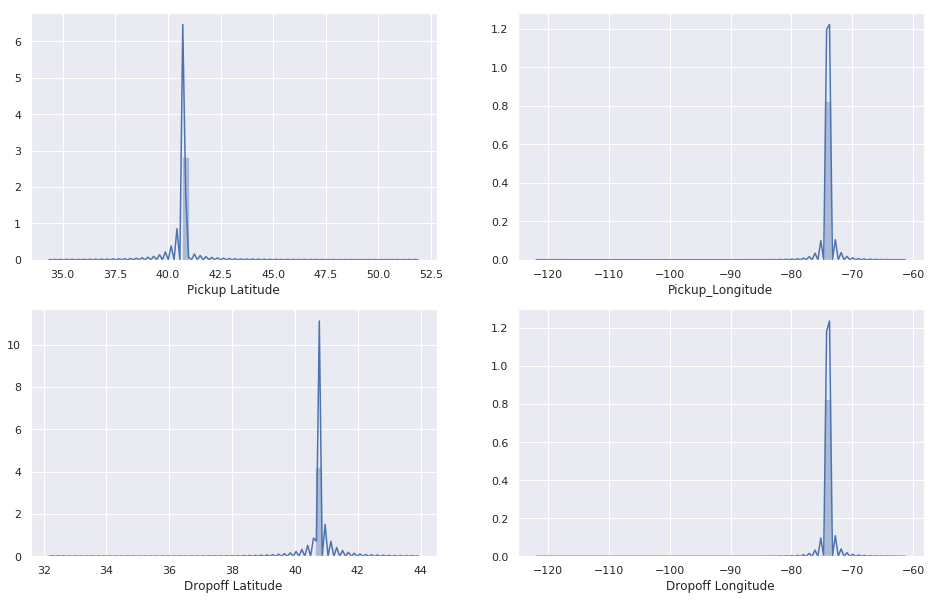

In [12]:
def plot_lat_long(df_data):
    fig, ax = plt.subplots(2,2,figsize=(16, 10), sharex=False, sharey = False)
    sns.distplot(df_data['pickup_latitude'], axlabel = 'Pickup Latitude',ax=ax[0,0])
    sns.distplot(df_data['pickup_longitude'], axlabel = 'Pickup_Longitude', ax=ax[0,1])
    sns.distplot(df_data['dropoff_latitude'], axlabel = 'Dropoff Latitude', ax=ax[1, 0])
    sns.distplot(df_data['dropoff_longitude'], axlabel = 'Dropoff Longitude', ax=ax[1, 1])
    plt.show()
plot_lat_long(df_train)

#### Drop Values Starting or Finishing out of New York City

Select values only within the NYC bounding Box

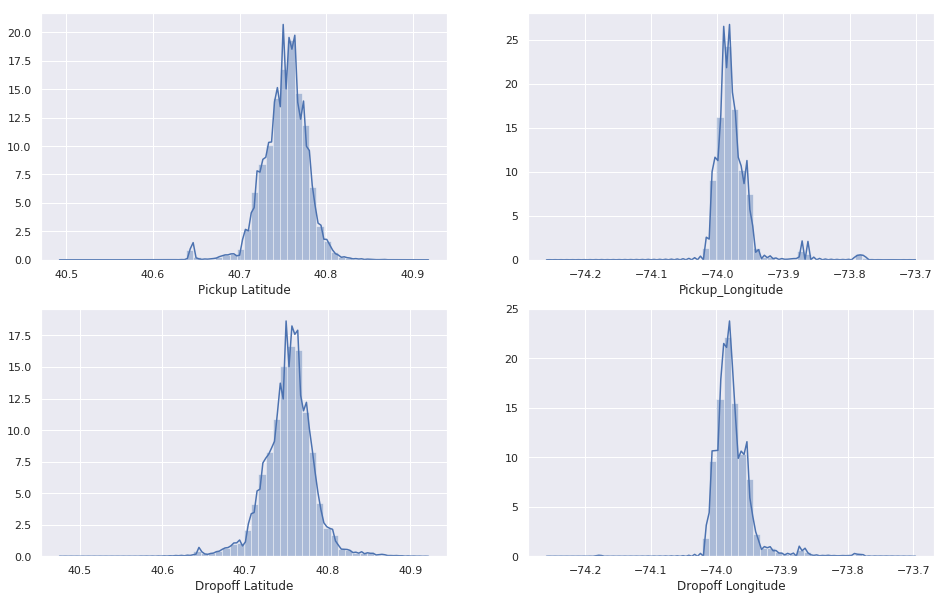

In [13]:
NYC_BOUNDING_BOX = [(40.4774,-74.2589), ( 40.9176, -73.7004)]

filter_lat_long = df_train['pickup_latitude'] < NYC_BOUNDING_BOX[1][0]
filter_lat_long &= df_train['pickup_latitude'] > NYC_BOUNDING_BOX[0][0]
filter_lat_long &= df_train['pickup_longitude'] < NYC_BOUNDING_BOX[1][1]
filter_lat_long &= df_train['pickup_longitude'] > NYC_BOUNDING_BOX[0][1]

filter_lat_long &= df_train['dropoff_latitude'] < NYC_BOUNDING_BOX[1][0]
filter_lat_long &= df_train['dropoff_latitude'] > NYC_BOUNDING_BOX[0][0]
filter_lat_long &= df_train['dropoff_longitude'] < NYC_BOUNDING_BOX[1][1]
filter_lat_long &= df_train['dropoff_longitude'] > NYC_BOUNDING_BOX[0][1]

df_train = df_train[filter_lat_long]

plot_lat_long(df_train)

#### Extracting New Features: DIstance and Average Speed

Two more features will be added using the fields provided. Since we have the coorinates from the pickup and dropoff points, we can calculate the distance between points. The distance function chosen for that is the Manhattan Distance, City Block distance or [Taxicab geometry](https://en.wikipedia.org/wiki/Taxicab_geometry). The final distance is given in Kilometers

The other feature is the average speed for the whole route, for that we will use the distance obtained in the previous step and the trip duration. The average speed will be in Kilometer per hour


In [14]:
NYC_DEGREE_KM = 111.05938787411571

def calculate_city_block_distance(df_data):
    delta_lat = np.absolute(df_data.pickup_latitude - df_data.dropoff_latitude) * NYC_DEGREE_KM    
    delta_lon = np.absolute(df_data.pickup_longitude - df_data.dropoff_longitude) * NYC_DEGREE_KM    
    return delta_lat + delta_lon


df_train['distance'] = calculate_city_block_distance(df_train)
df_train['avg_speed'] = df_train['distance']/(df_train['trip_duration']/3600)

### Analyzing Distance and Average Speed


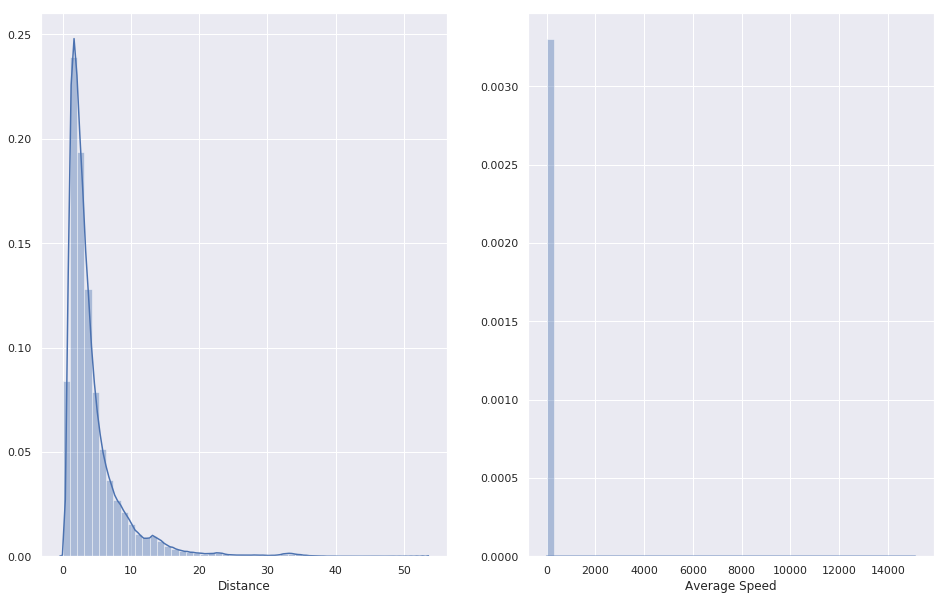

In [15]:
fig, ax = plt.subplots(1,2,figsize=(16, 10), sharex=False, sharey = False)
sns.distplot(df_train['distance'], axlabel = 'Distance',ax=ax[0])
sns.distplot(df_train['avg_speed'], axlabel = 'Average Speed',ax=ax[1])

Even filtering small values for trip duration, we still can find some values that must be removed, since it don't reflects the reality, as can be seen in the graph above, where average speeds of 800 Km/h can be seen. To remove more sporious rows, we'll remove the any value with average speeds greater than 120 Km/h.
Also distances close to 0 can be found and must be removed, for that we'll remove any values smaller than 0.250km

Even filtering the values, is possible to see that the distance distribution is skewed, for this case, we will later apply a logarithmic transformation.

In [16]:
df_train = df_train[df_train['avg_speed'] < 100]
df_train = df_train[df_train['avg_speed'] > 1]
df_train = df_train[df_train['distance'] > .1]
df_train.drop('avg_speed', axis=1, inplace=True)

#### Analyzing Pickup Date

As discussed before, only the pickup date will be used. A few features were created from the pickup datetime, they are justified by the typical behavior that we expect to see in the data, like "Rush Hours" or less traffic at weekends and Holidays. 

To analyze that behavior the following features were created: weekdays, holidays and pickup hour

In [17]:
df_train['pickup_date'] = df_train['pickup_datetime'].dt.date
df_train['pickup_hour'] = df_train['pickup_datetime'].dt.hour
df_train['pickup_weekday'] = df_train['pickup_datetime'].dt.day_name()

holidays = [day.date() for day in calendar().holidays(start=df_train['pickup_date'].min(), end=df_train['pickup_date'].max())]
df_train['holiday'] = df_train['pickup_date'].isin(holidays)
df_train.drop('pickup_date', axis=1, inplace=True)

#### Pickup Hour

In most of cities is expected a well defined behavior regarding populational flow within the city, this way makes a sense to analyze the average trip duration per hour of the day, as can be seen in the graph bellow.

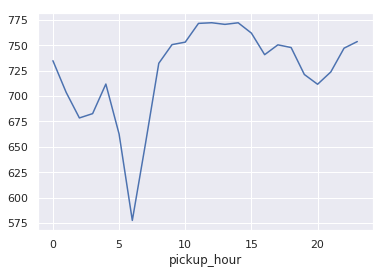

In [18]:
avg_trip_duration_per_pickup_hour = df_train.groupby('pickup_hour')['trip_duration'].mean()
avg_trip_duration_per_pickup_hour.plot()

#### Weekday vs Pickup Hour 

As shown in the graph bellow, different day of the week present a similar behavior, similar to the previous analysis, however the duration of each trip is different for each day of the week and in weekends the curves seen to be slightly shiffted by almost 2 hours.

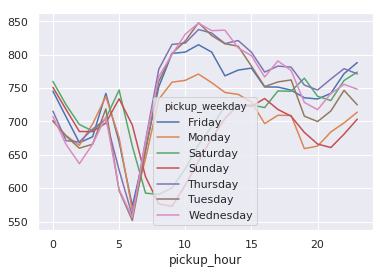

In [19]:
avg_trip_duration_per_weekday = df_train.groupby(['pickup_weekday', 'pickup_hour'])['trip_duration'].mean()
avg_trip_duration_per_weekday.unstack(level=0).plot(subplots=False)

#### Holidays

Applying the same analysis for holidays we have the graph bellow, which shows the average trip duration for a normal day and for a holiday. A similar behavior can be seen for both, however the curve for holiday is slightly shifted by a little more than 2 hours

holiday
False   736.408169
True    651.299037
Name: trip_duration, dtype: float64

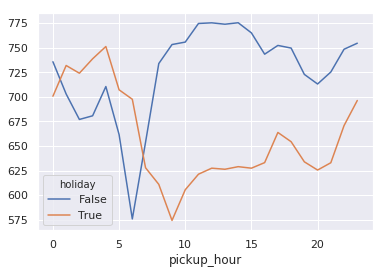

In [20]:
avg_trip_duration_holiday = df_train.groupby(['holiday','pickup_hour'])['trip_duration'].mean()
avg_trip_duration_holiday.unstack(level=0).plot(subplots=False)
df_train.groupby(['holiday'])['trip_duration'].mean()

#### Store and Forward

The store and forward at first look may not give any information about the trip duration, but looking the graph bellow, it becomes clear there is a difference between the two. That difference may be explained by the technologies available to drivers like navigation apps, Internet or more modern cars.

store_and_fwd_flag
N   734.340537
Y   822.473181
Name: trip_duration, dtype: float64

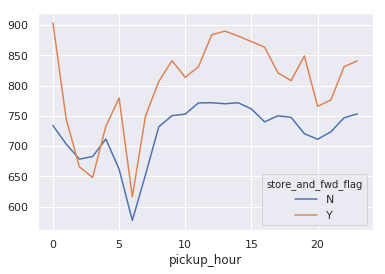

In [21]:
avg_trip_duration_per_store_flag = df_train.groupby(['store_and_fwd_flag','pickup_hour'])['trip_duration'].mean()
avg_trip_duration_per_store_flag.unstack(level=0).plot(subplots=False)
df_train.groupby(['store_and_fwd_flag'])['trip_duration'].mean()

#### Vendor ID

A naive analysis could lead to a misconception regarding the Vendor ID as a not usefull information, but given that technology has changed the private transportation market, a good routing or driver selection algorithm or papyment method can make a great difference in the trip_duration.

vendor_id
1   733.613303
2   735.807050
Name: trip_duration, dtype: float64

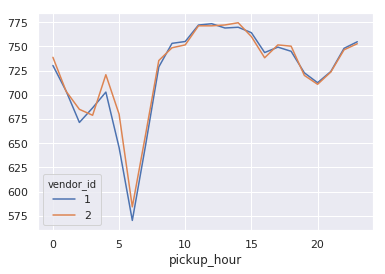

In [22]:
avg_trip_duration_per_store_flag = df_train.groupby(['vendor_id','pickup_hour'])['trip_duration'].mean()
avg_trip_duration_per_store_flag.unstack(level=0).plot(subplots=False)
df_train.groupby(['vendor_id'])['trip_duration'].mean()

#### Number of Passangers

In the same way as the previous analysis, it's worth to check the behavior of the number of passagengers transported and if it might give more infomation about the trip duration.

As can be seen bellow, the graph of number of passangers shows a similar behavior for each number of passangers.

In [23]:
df_train['passenger_count'].value_counts()
df_train = df_train[df_train['passenger_count']>0]
df_train = df_train[df_train['passenger_count']<7]

passenger_count
1   728.991587
2   753.627387
3   755.821157
4   759.310380
5   738.019152
6   732.238843
Name: trip_duration, dtype: float64

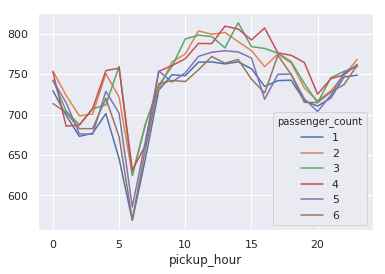

In [24]:
# avg_trip_duration_per_passenger_count = df_train.groupby(['passenger_count'])['trip_duration'].mean()
# avg_trip_duration_per_passenger_count.plot()
avg_trip_duration_per_passenger_count = df_train[df_train['passenger_count']>0].groupby(['passenger_count','pickup_hour'])['trip_duration'].mean()
avg_trip_duration_per_passenger_count.unstack(level=0).plot(subplots=False)
df_train.groupby(['passenger_count'])['trip_duration'].mean()

## Prepare the Data to build the models

After analyzing all the field, create more features and understanding a little more about its distribution, we have to process some of the field to prepare the data, making it more suitable to the models.

### One-hot enconding

To be properly used in supervised learning models the categorical fields independent of its type, must be transformed, since wrong information can be added to the model. One classical example of that are numerical categories where there is a logic relation between the numbers (greater than, sequences, , ratios, etc.) that might not exist in the category itself.


In [25]:
df_train = pd.get_dummies(df_train, columns=['vendor_id', 'passenger_count', 
                                    'store_and_fwd_flag', 'pickup_weekday', 'pickup_hour', 'holiday'])
cols = ['pickup_datetime', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude']

df_train.drop(cols, axis=1, inplace=True)
# df_train.drop(['pickup_datetime', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude'], axis=1, inplace=True)
df_train.columns

Index(['trip_duration', 'distance', 'vendor_id_1', 'vendor_id_2',
       'passenger_count_1', 'passenger_count_2', 'passenger_count_3',
       'passenger_count_4', 'passenger_count_5', 'passenger_count_6',
       'store_and_fwd_flag_N', 'store_and_fwd_flag_Y', 'pickup_weekday_Friday',
       'pickup_weekday_Monday', 'pickup_weekday_Saturday',
       'pickup_weekday_Sunday', 'pickup_weekday_Thursday',
       'pickup_weekday_Tuesday', 'pickup_weekday_Wednesday', 'pickup_hour_0',
       'pickup_hour_1', 'pickup_hour_2', 'pickup_hour_3', 'pickup_hour_4',
       'pickup_hour_5', 'pickup_hour_6', 'pickup_hour_7', 'pickup_hour_8',
       'pickup_hour_9', 'pickup_hour_10', 'pickup_hour_11', 'pickup_hour_12',
       'pickup_hour_13', 'pickup_hour_14', 'pickup_hour_15', 'pickup_hour_16',
       'pickup_hour_17', 'pickup_hour_18', 'pickup_hour_19', 'pickup_hour_20',
       'pickup_hour_21', 'pickup_hour_22', 'pickup_hour_23', 'holiday_False',
       'holiday_True'],
      dtype='object')

Also, as could be seen in the analysis above, some field present a very skewed distribution and apply a logarithmic transformation gives a better representation of the data distribution

In [26]:
df_train['trip_duration'] = np.log(df_train['trip_duration'] + 1)
df_train['distance'] = np.log(df_train['distance'] + 1)

## Training the Model

### Score Function

In the Kaggle competition there is no access to the true value of the trip duration for the test dataset and even though the score function is provided there is no way to calculate it. The only way to have the true score is subtmiting the values obtained when running the model to predict the trip duration for the Test dataset provided.

The score function chosen by the challenge is the [root mean square logarithmic error (RMSLE)](https://www.kaggle.com/c/nyc-taxi-trip-duration#evaluation), which is defined as follows:  

$$ \epsilon = \sqrt{ \frac{1}{n} \sum_{i=1}^{n} ( \log(p_i + 1) - \log(a_i + 1)  )^{2}    }  \;  $$

where $n$ is the total number of observations in the set, $p_i$ is the $i$-th trip_duration prediction, and $a_i$ is the $i$-th true value trip duration.

To train the models, we'll use the provided train dataset and split it in two sets, a Train and a Test set to evaluate the models, using it as to compare the models performance. The split will follow the proportion of 70% for the Train dataset and 30% for the Test dataset


In [27]:
def kaggle_score(y_true_exp, y_pred_exp):
    y_pred_exp = np.exp(y_pred_exp) - 1
    y_true_exp = np.exp(y_true_exp) - 1
    e_log_square = np.square( np.log(y_pred_exp + 1) - np.log(y_true_exp + 1))
    score = np.sqrt((1/len(y_true_exp)) * np.sum(e_log_square))
    return score

#### Spliting the whole train dataset using train_test_split

In [28]:
from sklearn.model_selection import train_test_split

df_y_train = df_train['trip_duration']
df_X_train = df_train.drop(columns=['trip_duration'])

X_train, X_test, y_train, y_test = train_test_split(df_X_train,
                                                    df_y_train,
                                                    test_size = 0.3,
                                                    random_state = 3)

## Model Selection

### Linear Regression

To understand better the performance and the capabilities of a model and have quick first insights about how the data is being pre processed and is being predicted. 

With that in mind, the first chosen model is [Linear Regression](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html)

In [30]:
%%time
from sklearn.linear_model import LinearRegression
model = LinearRegression()
clf = model.fit(X_train, y_train)
y_pred = clf.predict(X_test)
final_score = kaggle_score( y_test, y_pred)
                           
print(f'Linear Regression Score: {final_score}')

Linear Regression Score: 0.42772463461077576
CPU times: user 1.6 s, sys: 715 ms, total: 2.31 s
Wall time: 1.24 s


### Lasso

Changing a little the approach, we'll use another linear regression model, using L1 regularisation. The L1 regularization limits the size of the coefficients by applying a penalty equals to the absolute value of the magnitude of coefficients

In [31]:
%%time
from sklearn.linear_model import Lasso
model = Lasso(random_state=3)
clf = model.fit(X_train, y_train)
y_pred = clf.predict(X_test)
final_score = kaggle_score( y_test, y_pred)
                           
print(f'Lasso Score: {final_score}')

Lasso Score: 0.6725745338011018
CPU times: user 538 ms, sys: 533 ms, total: 1.07 s
Wall time: 588 ms


### Ridge

Ridge is another linear regression model, but using a L2 regularization. The L2 penalty to the coefficients is equal to the square root of the coefficients magnitudes. 

In [32]:
%%time
from sklearn.linear_model import Ridge
model = Ridge(random_state=3)
clf = model.fit(X_train, y_train)
y_pred = clf.predict(X_test)
final_score = kaggle_score( y_test, y_pred)
                           
print(f'Ridge Score: {final_score}')

Ridge Score: 0.4277240533226883
CPU times: user 498 ms, sys: 323 ms, total: 821 ms
Wall time: 411 ms


### Decision Tree Regressor

Basically, the decision tree model works like a series of if-else questions for the different features presents in the dataset that leads to a understanding of the behaviour of the target variable according to how the features change.

Oftenly, decision trees might lead to the model overfitting the train dataset if no pruning if applyed to the tree.

In [33]:
%%time
from sklearn.tree import DecisionTreeRegressor
model = DecisionTreeRegressor(random_state=3)
clf = model.fit(X_train, y_train)
y_pred = clf.predict(X_test)
final_score = kaggle_score( y_test, y_pred)
                           
print(f'Decision Tree Regressor Score: {final_score}')

Decision Tree Regressor Score: 0.568131730069767
CPU times: user 13.3 s, sys: 531 ms, total: 13.9 s
Wall time: 13.5 s


### Random Forest Regressor

Random Forest is an ensemble method that uses a set of slightly different decision trees to fit the model, the idea behind that is to avoid the overfitting, which is commom to decision trees, by using randomly different number of features ramdomly chosen for each decision tree, averaging their results to find a final model that is more balanced 

In [34]:
%%time
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor(random_state=3)
clf = model.fit(X_train, y_train)
y_pred = clf.predict(X_test)
final_score = kaggle_score( y_test, y_pred)

print(f'Random Forest Regressor Score: {final_score}')

/home/luciano/Install/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Random Forest Regressor Score: 0.45598979449492705
CPU times: user 1min 31s, sys: 818 ms, total: 1min 32s
Wall time: 1min 31s


### Gradient Boosting Regressor

Gradient Boosted trees is another ensemble method that combines multiple decision trees to compose a better and more precise final model. 

Differently from the Random Forest, the decision trees are not created in an random way, instead the trees are created in a more serial manner, with one tree trying to correct mistakes from the previous one. The algorithm uses strong pre-prunning, leading to a final model composed of shallow trees. This carachteristic contributes to a faster training that consumes less memory

In [35]:
%%time
from sklearn.ensemble import GradientBoostingRegressor
model = GradientBoostingRegressor(random_state=3)
clf = model.fit(X_train, y_train)
y_pred = clf.predict(X_test)
final_score = kaggle_score( y_test, y_pred)

print(f'Gradient Boosting Regressor Score: {final_score}')

Gradient Boosting Regressor Score: 0.40877528042762556
CPU times: user 2min 39s, sys: 1.2 s, total: 2min 40s
Wall time: 2min 44s


### XGBoost: Extreme Gradient Boosting

XGBoost is another ensemble Boosting algorithm, it uses a set shallow decision trees to produce a more powerful final model. XGBoost is portable, efficient, scalable, accurate and flexible what makes it a odel worth trying in the challenge

In [36]:
%%time
import xgboost as xgb
model = xgb.XGBRegressor(random_state=3)
clf = model.fit(X_train, y_train)
y_pred = clf.predict(X_test)
final_score = kaggle_score( y_test, y_pred)

print(f'XGBoost Score: {final_score}')

XGBoost Score: 0.40888857095046693
CPU times: user 1min 59s, sys: 1.64 s, total: 2min
Wall time: 2min 7s


### Adaboost Regressor

Adaboost is another ensemble method that uses a weighted combination of weak learners (models slightly better then a random guess) to produce the final result.

It's a simple iteractive method that uses a sample of the data with the same weight to all the points to train weak learners, those are used to predict the target value, which is compared to the true one. In the next iteractions the points with the bigger error receives the higher weight and the process starts again. 

The training ceases when the error functions is the same between interactions or the number o the total number of estimators is reached.

In [37]:
%%time
from sklearn.ensemble import AdaBoostRegressor
model = AdaBoostRegressor(random_state=3)
clf = model.fit(X_train, y_train)
y_pred = clf.predict(X_test)
final_score = kaggle_score( y_test, y_pred)

print(f'Gradient Boosting Regressor Score: {final_score}')

Gradient Boosting Regressor Score: 0.43804008122671456
CPU times: user 1min 29s, sys: 2.09 s, total: 1min 31s
Wall time: 1min 31s


### Scores of each model

As describe before the scoreing fucntion measures the error, thus a smaller error will mean a better score. Bellow are all the models evaluated in order from the best performing to the worst performing

1. __Gradient Boosting:__ 0.40877528042762556
1. __XGBoost:__ 0.40888857095046693
1. __Ridge:__ 0.4277240533226883
1. __Linear Regression:__ 0.42772463461077576
1. __AdaBoost:__ 0.43804008122671456
1. __Random Forest:__ 0.45598979449492705
1. __Decision Tree:__ 0.568131730069767
1. __Lasso:__ 0.6725745338011018

## Fine tunning the 3 best models

#### Grid Search and Cross Validation

Cross-validation is a technique to verify how robust and general is the model when making predictions to different datasets.

In cross-validation the original data set is divided in $k$ parts of the same size, in each interaction the model to be validated is trained using $k-1$ parts and later predicts the target variable in the remaining part of the original dataset and a score is calculated with a determined score function.

After calculating the score for the configuration of train/test datasets, the dataset which was used to test becomes part of the training dataset and one of the parts that belonged to the train dataset becomes the test dataset and the process repeats until all the $k$ parts were used as test dataset. The final score for the model is the average of the scores found in each interaction

Simultaneously with the cross validation, scikit-learn uses the GridSearch. GridSearch implements an exhaustive search method through all the different combinations of Hyperparameters that the user wants to test in the model and with the help of cross validation evaluate which combination of the hyperparameters gives the best result for the dataset.


#### The best 3 models

For this section we'll only work with the 3 best performing models, that is the models with the lower values for the scores. In the next section we'll be using the Ridge, Gradient Boost and XGBoost regression models.

In [38]:
best_models = {}

#### Ridge Hyperparameters Tunnning

The score for Ridge using the default parameters was 0.4277240533226883

The fine tunning tested the combination of the following parameters for the model using 3-fold cross-validation to evaluate the best result:

* alpha: 0.5, 1.0, 3.0, 4.0, 5.0, 10.0
* solver: *auto*, *least-squares* (lsqr), *Stochastic Average Gradient descent* (SAG), *Singular Value Decomposition* (SVD)

The final parameter chosen was *alpha* = 5.0 and *solver* = *svd*, which had no practical improvement, with the score of 0.4277241321921506

In [39]:
%%time
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

model = Ridge(random_state=3)
scorer = make_scorer(kaggle_score, greater_is_better= False)

parameters = {
    'alpha': [0.5, 1.0, 3.0, 4.0, 5.0, 10.0],
    'solver': ['auto', 'lsqr', 'sag', 'svd']
}
clf = GridSearchCV(model, param_grid=parameters, scoring=scorer, verbose=10, n_jobs=-1, cv=3)
grid_fit = clf.fit(X_train, y_train)

best_params = grid_fit.best_params_
best_clf = grid_fit.best_estimator_
final_score = kaggle_score(y_test, best_clf.predict(X_test))
best_models['Ridge'] = {
    'final_score':final_score,
    'clf':best_clf,
    'params':best_params
}

print(f'Ridge best parameters: {best_params}')
print(f'Ridge Score: {final_score}')

Fitting 3 folds for each of 24 candidates, totalling 72 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:   10.7s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   29.1s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   44.2s
/home/luciano/Install/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done  72 out of  72 | elapsed:  3.2min finished


Ridge best parameters: {'alpha': 0.5, 'solver': 'sag'}
Ridge Score: 0.4277241321921506
CPU times: user 1min 52s, sys: 7.62 s, total: 2min
Wall time: 3min 35s


In [40]:
%%time
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

model = RandomForestRegressor(random_state=3)
scorer = make_scorer(kaggle_score, greater_is_better= False)

parameters = {
    'n_estimators': [80, 150],
    'max_depth': [None, 10, 50],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 4]
}
clf = GridSearchCV(model, param_grid=parameters, scoring=scorer, verbose=10, n_jobs=4, cv=2)
grid_fit = clf.fit(X_train, y_train)

best_params = grid_fit.best_params_
best_clf = grid_fit.best_estimator_
final_score = kaggle_score(y_test, best_clf.predict(X_test))
best_models['RandomForest'] = {
    'final_score':final_score,
    'clf':best_clf,
    'params':best_params
}

print(f'Random Forest best parameters: {best_params}')
print(f'Random Forest Score: {final_score}')

Fitting 2 folds for each of 24 candidates, totalling 48 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed: 26.0min
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed: 43.0min
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed: 69.9min
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed: 80.8min
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed: 101.3min
[Parallel(n_jobs=4)]: Done  46 out of  48 | elapsed: 154.2min remaining:  6.7min
[Parallel(n_jobs=4)]: Done  48 out of  48 | elapsed: 162.3min finished


Random Forest best parameters: {'max_depth': 50, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 150}
Random Forest Score: 0.4148110156535417
CPU times: user 21min 11s, sys: 9.13 s, total: 21min 20s
Wall time: 3h 2min 36s


### Gradient Boosting Regressor Hyperparameters Tunnning

The score for Gradient Boosting Regressor using the default parameters was 0.40877528042762556.

The fine tunning tested the combination of the following parameters for the model using 2-fold cross-validation to evaluate the best result:

* max_depth: 3, 5
* n_estimators: 100, 200
* min_samples_split: 2, 6
* learning_rate : 0.1, 1.0

The final parameters chosen was *learning_rate*: 0.1, *max_depth*: 5, *min_samples_split*: 6, *n_estimators*: 200, which improved the score to 0.3985323203593734

In [41]:
%%time
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

model = GradientBoostingRegressor(random_state=3)
scorer = make_scorer(kaggle_score, greater_is_better= False)

parameters = {
    'max_depth': [3, 5],
    'n_estimators': [100, 200],
    'min_samples_split': [2, 6],
    'learning_rate': [0.1, 1.0]
}

clf = GridSearchCV(model, param_grid=parameters, scoring=scorer, verbose=10, cv=2, n_jobs=4)
grid_fit = clf.fit(X_train, y_train)

best_params = grid_fit.best_params_
best_clf = grid_fit.best_estimator_
final_score = kaggle_score(y_test, best_clf.predict(X_test))
best_models['GradientBoost'] = {
    'final_score':final_score,
    'clf':best_clf,
    'params':best_params
}

print(f'Gradient Boosting Regressor best parameters: {best_params}')
print(f'Gradient Boosting Regressor  Score: {final_score}')

Fitting 2 folds for each of 16 candidates, totalling 32 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:  4.4min
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed: 10.7min
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed: 25.1min
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed: 31.7min
[Parallel(n_jobs=4)]: Done  29 out of  32 | elapsed: 42.2min remaining:  4.4min
[Parallel(n_jobs=4)]: Done  32 out of  32 | elapsed: 45.9min finished


Gradient Boosting Regressor best parameters: {'learning_rate': 0.1, 'max_depth': 5, 'min_samples_split': 6, 'n_estimators': 200}
Gradient Boosting Regressor  Score: 0.3985323203593734
CPU times: user 12min 52s, sys: 4.32 s, total: 12min 56s
Wall time: 58min 6s


### XGBoost Hyperparameters Tunnning

The score for XGBoost Regressor using the default parameters was 0.40888857095046693.

The fine tunning tested the combination of the following parameters for the model using 2-fold cross-validation to evaluate the best result:

* max_depth: 5, 8, 10
* n_estimators: 200, 300
* learning_rate: 0.05, 0.1
* reg_lambda: 1.0, 5

The final parameters chosen was *learning_rate*: 0.1, *max_depth*: 5, *n_estimators*: 300, *reg_lambda*: 5, which improved the score to 0.3981089784145823

In [42]:
%%time
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

model = xgb.XGBRegressor(random_state=3)
scorer = make_scorer(kaggle_score, greater_is_better=False)

parameters = {
    'max_depth': [5, 8, 10],
    'n_estimators': [200, 300],
    'learning_rate': [0.05, 0.1,],
    'reg_lambda': [1.0, 5] }

clf = GridSearchCV(model, param_grid=parameters, scoring=scorer, verbose=10, cv=2, n_jobs=4)
grid_fit = clf.fit(X_train, y_train)

best_params = grid_fit.best_params_
best_clf = grid_fit.best_estimator_
final_score = kaggle_score(y_test, best_clf.predict(X_test))
best_models['XGBoost'] = {
    'final_score':final_score,
    'clf':best_clf,
    'params':best_params
}

print(f'XGBoost best parameters: {best_params}')
print(f'XGBoost Score: {final_score}')

Fitting 2 folds for each of 24 candidates, totalling 48 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed: 13.9min
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed: 23.2min
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed: 45.5min
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed: 61.5min
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed: 80.1min
[Parallel(n_jobs=4)]: Done  46 out of  48 | elapsed: 117.2min remaining:  5.1min
[Parallel(n_jobs=4)]: Done  48 out of  48 | elapsed: 117.2min finished


XGBoost best parameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 300, 'reg_lambda': 5}
XGBoost Score: 0.3981089784145823
CPU times: user 8min 9s, sys: 4.89 s, total: 8min 14s
Wall time: 2h 4min 29s


### Tunning Analysis

After fine tunning the  3 best performing models, the on that presented the best score was once again the XGBoost. One thing worth noticing is the average time used to validate each of the parameters: 

* Ridge: 72 fits run in 3 minutes and 35 seconds
* Gradient Boosting: 32 fits in 58 minutes and 6 seconds
* XGBoost: 48 fits in 2 hours, 4 minutes and 29 seconds

Also, the gain obtained in this phase was quite small, specially in the Ridge Model:

* XGBoost: 0.010779592535884619
* Gradient Boosting: 0.01024296006825215
* Ridge: 7.886946229440639e-08
 

The final score after tunning the Hyperparamenters are:

1. XGBoost: 0.3981089784145823
1. Gradient Boosting: 0.3985323203593734
1. Ridge: 0.4277241321921506

## Predicting the Original Test Dataset and submitting to Kaggle

THe Kaggle challenge was already finished, but still accepts late submissions, so we'll use our 3 best models after the fine tunning and make the late submission to get the real submission score.

Before applying the model to the original test dataset, we must create the same features that were created in the model exploration and fine tunning.

Also, the dimensions for train and test dataset must be the same, with the same column names. As we dropped any data for trips with 0 or 9 passangers, the columns generated with the *pd.get_dummies* (passenger_count_0 and passenger_count_9) must also be dropped in the test dataset

In [46]:
df_test = pd.read_csv(PATH_TEST_DATASET, infer_datetime_format=True, parse_dates=['pickup_datetime'],  index_col='id')
# df_test['pickup_datetime'] = df_test['pickup_datetime'].dt.to_pydatetime()
df_test['pickup_date'] = df_test['pickup_datetime'].dt.date
df_test['pickup_hour'] = df_test['pickup_datetime'].dt.hour
df_test['pickup_weekday'] = df_test['pickup_datetime'].dt.day_name()

holidays = [day.date() for day in calendar().holidays(start=df_test['pickup_date'].min(), end=df_test['pickup_date'].max())]
df_test['holiday'] = df_test['pickup_date'].isin(holidays)
df_test.drop('pickup_date', axis=1, inplace=True)
df_test['distance'] = calculate_city_block_distance(df_test)
df_test['distance'] = np.log(df_test['distance'] + 1)
df_test = pd.get_dummies(df_test, columns=['vendor_id', 'passenger_count', 
                                    'store_and_fwd_flag', 'pickup_weekday', 'pickup_hour', 'holiday'])
df_test.drop(['pickup_datetime', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude'], axis=1, inplace=True)
df_test.drop(['passenger_count_0', 'passenger_count_9'], axis=1, inplace=True)

#### Creating the submission file

The submission file must be formatted to be accepted by the automated submission scoring system. A sample of the final format is given with the datasets in the Challenge's page.

In [47]:
import os
BASE_PATH_KAGGLE_SUBMISISON = './out'

def create_txt_file_for_submission(df_data, file_name):
    
    final_path = os.path.abspath(os.path.join(BASE_PATH_KAGGLE_SUBMISISON,file_name))
    final_path += '.txt'
    df_data.index.name = 'id'
    print(final_path)
    df_data.to_csv(final_path,
                   sep=',',
                   header=True,
                   na_rep=df_data['trip_duration'].quantile(0.5)
                  )
   

#### Predicting the trip duration for the original test dataset

As we stored the best models we'll now use an empty copy of them with the same parameters and train that again now with the whole original train dataset to get a better model for the final submission.

After predicting the values for trip duration one submission file will be prepared for each model.

In [48]:
for model_name, model_specs in best_models.items():
    clf = sklearn.base.clone(model_specs['clf'])
    clf.fit(df_X_train, df_y_train)
    y_predict = clf.predict(df_test)
    y_predict = np.exp(y_predict) - 1
    df_result = pd.DataFrame(y_predict, columns=['trip_duration'], index=df_test.index.values)
    create_txt_file_for_submission(df_result, model_name)

/home/luciano/Personal/udacity/udacity_capstone_project/out/Ridge.txt
/home/luciano/Personal/udacity/udacity_capstone_project/out/RandomForest.txt
/home/luciano/Personal/udacity/udacity_capstone_project/out/GradientBoost.txt
/home/luciano/Personal/udacity/udacity_capstone_project/out/XGBoost.txt


## The final results

After submiting the prediction for each model, the final Scores are as follows:

1. XGBoost: 0.49571
1. Gradient Boost: 0.49750
1. Ridge: 0.51109

## Achievements and Improvements

Throughout the project, many topics related do data manipulation and visualization were covered, from opening the files, describing each of the columns, checking for null data, ploting the distributions, checking outliers, creating new features combining multiple columns, building simple models and evaluate them, fining tunning the best. 

The results achieved are coherent with the proposal, in which a score of 0.5 was the final goal.

In the matter of improvements, the first step would be to play more with the hyperparameters to fine tunne them evn more, another point of improvement is to understand better in what areas the traffic is more intense by using clusterization for example, also is a good idea to add more sources of data like weather that have a big impact in trip duration.